In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
from PCA_NP import pca_np

In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
#read all images from the folder
def read_images(folder_images, folder_masks):
    dict_images = {}
    for filename in os.listdir(folder_images):
        img = Image.open(os.path.join(folder_images, filename))
        mask = Image.open(os.path.join(folder_masks, filename.split('.')[0] + '_segmentation.png'))
        if img is not None and mask is not None:
            dict_images[filename.split('.')[0]] = {}
            dict_images[filename.split('.')[0]]['image'] = img
            dict_images[filename.split('.')[0]]['mask'] = mask
            matrices, explained_var_scores = pca_np(np.array(img))
            dict_images[filename.split('.')[0]]['pca'] = (matrices, explained_var_scores)
    return dict_images

In [6]:
folder_images = '../../data/skincancer_new_processed/test/images'
folder_masks = '../../data/skincancer_new_processed/test/masks'

In [7]:
images_dict = read_images(folder_images, folder_masks)

In [8]:
#DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem[1]['pca'][1])
#    if i == 0:
#        break

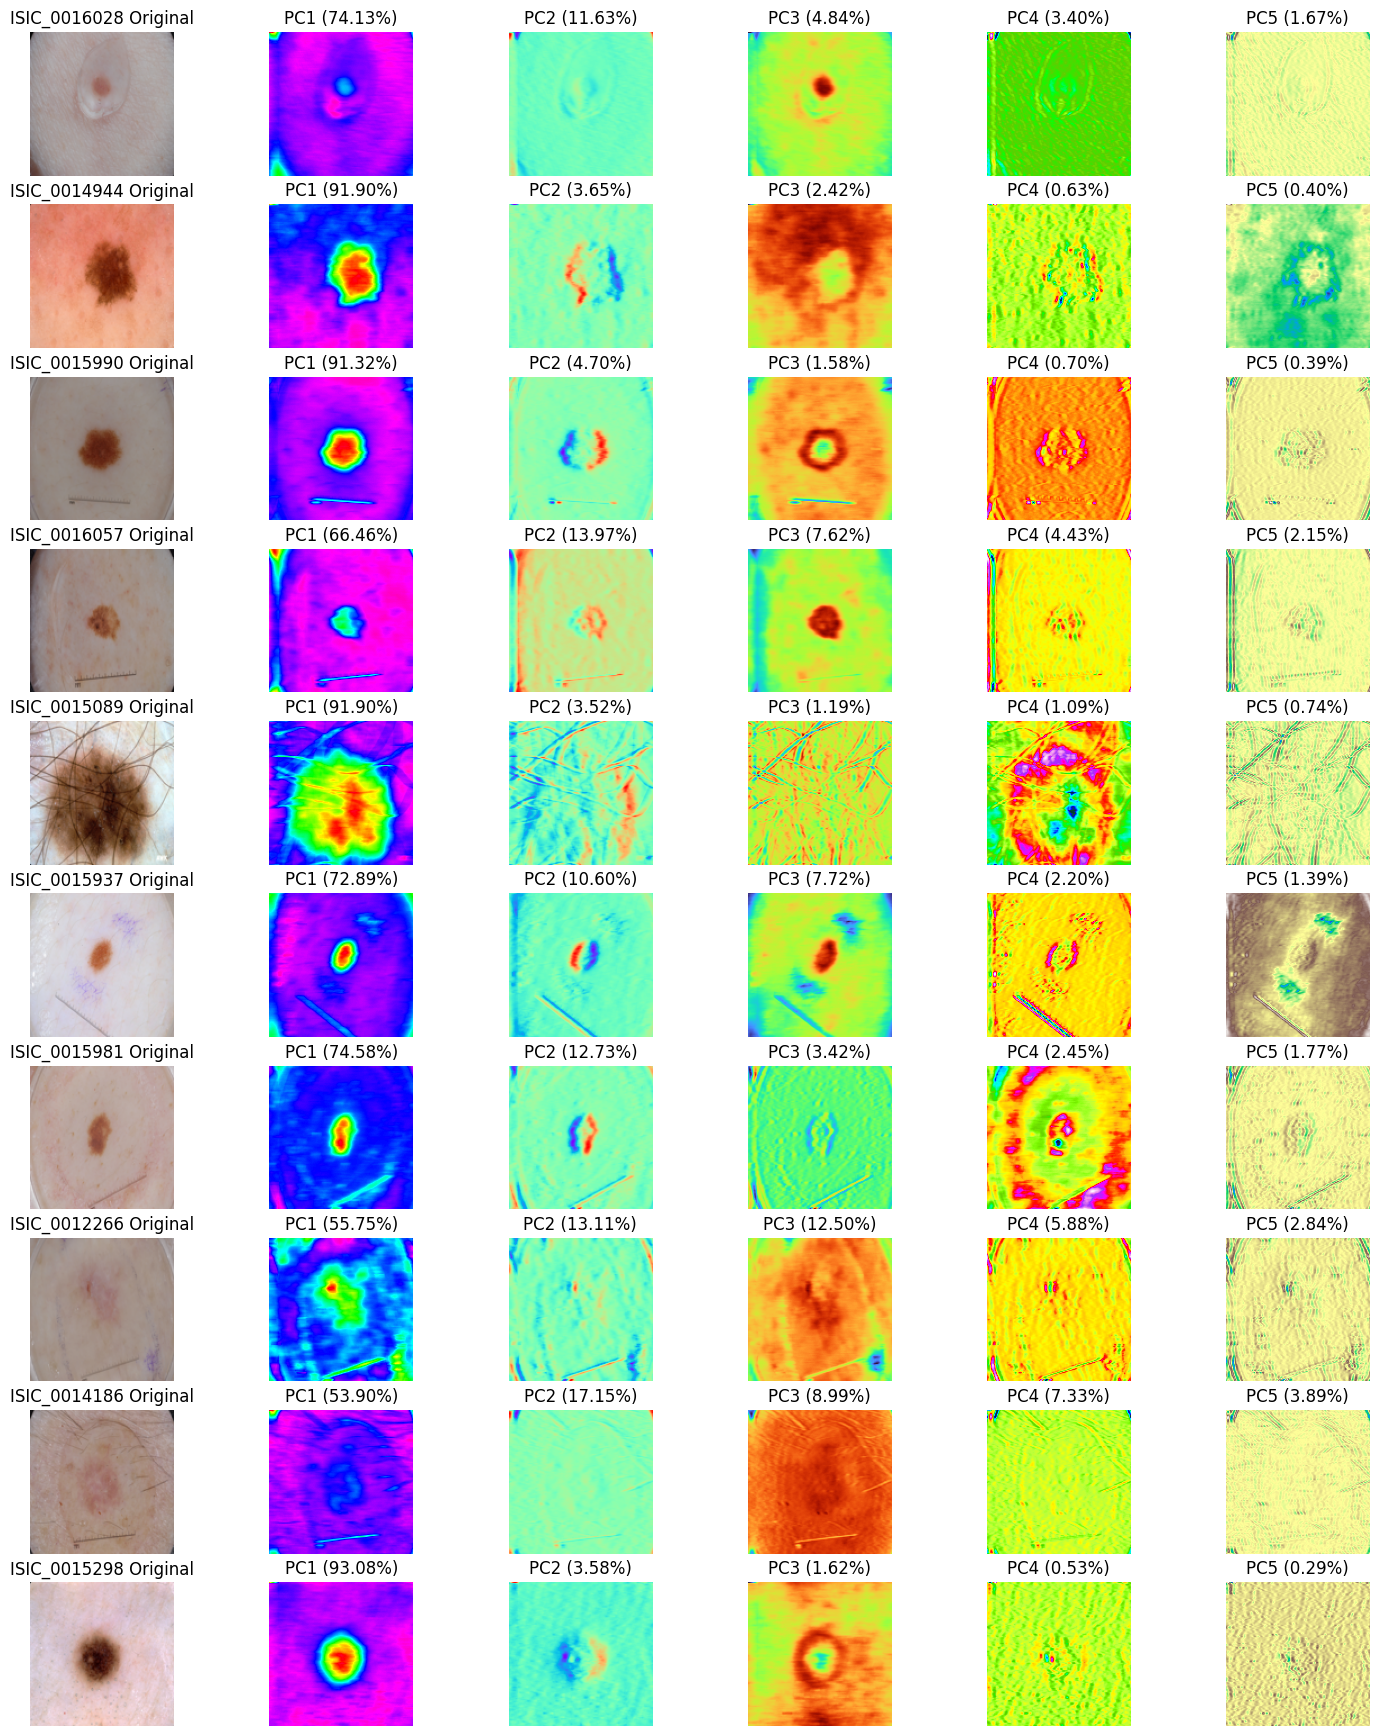

In [9]:
# plot the pca_np image
fig, ax = plt.subplots(10, 6, figsize=(18, 22))
colors = ['gist_rainbow', 'rainbow', 'turbo', 'gist_ncar', 'terrain']
for i, item in enumerate(images_dict.items()):
    if i == 10:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    for j, matrix in enumerate(item[1]['pca'][0]):
        ax[i, j+1].imshow(matrix, cmap=colors[j])
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'PC{j+1} ({item[1]['pca'][1][j]:.2f}%)')

In [10]:
# function to calculate dice score given two numpy masks
def dice_score(mask1, mask2):
    mask1 = np.asarray(mask1).astype(bool)
    mask2 = np.asarray(mask2).astype(bool)
    intersection = np.sum(mask1 & mask2)
    dice = 2 * intersection / (np.sum(mask1) + np.sum(mask2))
    return dice

# function to calculate the IoU score given two numpy masks
def iou_score(mask1, mask2):
    intersection = np.logical_and(mask1, mask2)
    union = np.logical_or(mask1, mask2)
    return intersection.sum() / union.sum()

In [11]:
for i, item in enumerate(images_dict.items()):
    predictor.set_image(np.array(item[1]['image']))
    images_dict[item[0]]['predicted_masks_pca'] = []
    images_dict[item[0]]['dice_scores_predicted_masks_pca'] = []
    images_dict[item[0]]['iou_scores_predicted_masks_pca'] = []
    #if i == 5:
    #    break
    for j, matrix in enumerate(item[1]['pca'][0]):
            
            # apply convolutional filter to the matrix using cv2
            kernel = np.ones((5,5),np.float32)/25
            matrix = cv2.filter2D(matrix,-1,kernel)
            ## binarize the matrix
            mean_value = np.mean(matrix)
            std_value = np.std(matrix)
            matrix[matrix < mean_value + 2*std_value] = 0
            matrix[matrix > mean_value + 2*std_value ] = 1

            matrix_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
            matrix_sam_fixed[0] = cv2.resize(matrix, (256, 256), interpolation=cv2.INTER_LINEAR)
            matrix_sam_fixed = 1 - matrix_sam_fixed

            #fig, ax = plt.subplots(1, 2)
            #ax[0].imshow(item[1]['image'])
            #ax[0].axis('off')
            #ax[0].set_title(item[0] + ' Original')
            #ax[1].imshow(matrix_sam_fixed[0], cmap='gray')
            #ax[1].axis('off')
            #ax[1].set_title(f'PC{j+1} ({item[1]['pca'][1][j]:.2f}%)')
            #plt.show()

            masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = 1 - masks[1] # get the second mask
            #mask, _, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=False)
            mask = np.array(mask).astype(np.float32)
            images_dict[item[0]]['predicted_masks_pca'].append(mask)
            # calculate dice and iou scores
            dice = dice_score(np.array(item[1]['mask']), mask)
            iou = iou_score(np.array(item[1]['mask']), mask)
            images_dict[item[0]]['dice_scores_predicted_masks_pca'].append(dice)
            images_dict[item[0]]['iou_scores_predicted_masks_pca'].append(iou)

In [12]:
##DEBUGGING PURPOSES
#for i, elem in enumerate(images_dict.items()):
#    print(elem)
#    if i == 0:
#        break

In [13]:
images_names = []
dice_scores_pca1 = []
iou_scores_pca1 = []
dice_scores_pca2 = []
iou_scores_pca2 = []
dice_scores_pca3 = []
iou_scores_pca3 = []
dice_scores_pca4 = []
iou_scores_pca4 = []
dice_scores_pca5 = []
iou_scores_pca5 = []
for i, elem in enumerate(images_dict.items()):
    images_names.append(elem[0])
    dice_scores_pca1.append(elem[1]['dice_scores_predicted_masks_pca'][0])
    iou_scores_pca1.append(elem[1]['iou_scores_predicted_masks_pca'][0])
    dice_scores_pca2.append(elem[1]['dice_scores_predicted_masks_pca'][1])
    iou_scores_pca2.append(elem[1]['iou_scores_predicted_masks_pca'][1])
    dice_scores_pca3.append(elem[1]['dice_scores_predicted_masks_pca'][2])
    iou_scores_pca3.append(elem[1]['iou_scores_predicted_masks_pca'][2])
    dice_scores_pca4.append(elem[1]['dice_scores_predicted_masks_pca'][3])
    iou_scores_pca4.append(elem[1]['iou_scores_predicted_masks_pca'][3])
    dice_scores_pca5.append(elem[1]['dice_scores_predicted_masks_pca'][4])
    iou_scores_pca5.append(elem[1]['iou_scores_predicted_masks_pca'][4])

In [14]:
df_res = pd.DataFrame({'Image': images_names, 'Dice PCA1': dice_scores_pca1, 'IoU PCA1': iou_scores_pca1, 'Dice PCA2': dice_scores_pca2, 'IoU PCA2': iou_scores_pca2, 'Dice PCA3': dice_scores_pca3, 'IoU PCA3': iou_scores_pca3, 'Dice PCA4': dice_scores_pca4, 'IoU PCA4': iou_scores_pca4, 'Dice PCA5': dice_scores_pca5, 'IoU PCA5': iou_scores_pca5})
df_res

Image  Dice PCA1  IoU PCA1  Dice PCA2  IoU PCA2  Dice PCA3  \
0    ISIC_0016028   0.039722  0.020264   0.039722  0.020264   0.039722   
1    ISIC_0014944   0.932924  0.874281   0.931920  0.872519   0.932924   
2    ISIC_0015990   0.428744  0.272867   0.428325  0.272528   0.437313   
3    ISIC_0016057   0.085189  0.044489   0.085199  0.044495   0.085199   
4    ISIC_0015089   0.722935  0.566091   0.647314  0.478540   0.723299   
..            ...        ...       ...        ...       ...        ...   
595  ISIC_0015215   0.304460  0.179565   0.304460  0.179565   0.304460   
596  ISIC_0015142   0.680387  0.515595   0.680469  0.515690   0.680359   
597  ISIC_0016015   0.130534  0.069824   0.130534  0.069824   0.130534   
598  ISIC_0012722   0.025621  0.012977   0.025604  0.012968   0.025607   
599  ISIC_0013814   0.808028  0.677891   0.808028  0.677891   0.808028   

     IoU PCA3  Dice PCA4  IoU PCA4  Dice PCA5  IoU PCA5  
0    0.020264   0.039722  0.020264   0.039722  0.020264  
1    0.874281   0.932987  0.874392   0.933113  0.874612  
2    0.279847   0.460341  0.298989   0.450509  0.290747  
3    0.044495   0.085099  0.044440   0.085099  0.044440  
4    0.566538   0.722835  0.565968   0.722885  0.566030  
..        ...        ...       ...        ...       ...  
595  0.179565   0.304460  0.179565   0.304460  0.179565  
596  0.515564   0.680387  0.515595   0.680387  0.515595  
597  0.069824   0.130534  0.069824   0.130534  0.069824  
598  0.012969   0.025619  0.012976   0.025613  0.012973  
599  0.677891   0.806938  0.676359   0.808028  0.677891  

[600 rows x 11 columns]

In [15]:
df_res.describe()

Dice PCA1    IoU PCA1   Dice PCA2    IoU PCA2   Dice PCA3    IoU PCA3  \
count  600.000000  600.000000  600.000000  600.000000  600.000000  600.000000   
mean     0.371861    0.268239    0.371059    0.266004    0.369094    0.265103   
std      0.272825    0.241812    0.268000    0.236270    0.270078    0.238277   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.123653    0.065901    0.127665    0.068185    0.123679    0.065916   
50%      0.320727    0.190992    0.328760    0.196716    0.326270    0.194938   
75%      0.580166    0.408615    0.578384    0.406850    0.574607    0.403122   
max      0.993814    0.987704    0.994121    0.988312    0.994083    0.988235   

        Dice PCA4    IoU PCA4   Dice PCA5    IoU PCA5  
count  600.000000  600.000000  600.000000  600.000000  
mean     0.367976    0.263975    0.371294    0.266672  
std      0.268695    0.237972    0.269192    0.238262  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.124910    0.066616    0.125462    0.066930  
50%      0.322669    0.192372    0.328760    0.196716  
75%      0.572230    0.400786    0.576256    0.404748  
max      0.994083    0.988235    0.993930    0.987932

In [16]:
df_res.to_csv('pca_nb_results.csv', index=False)

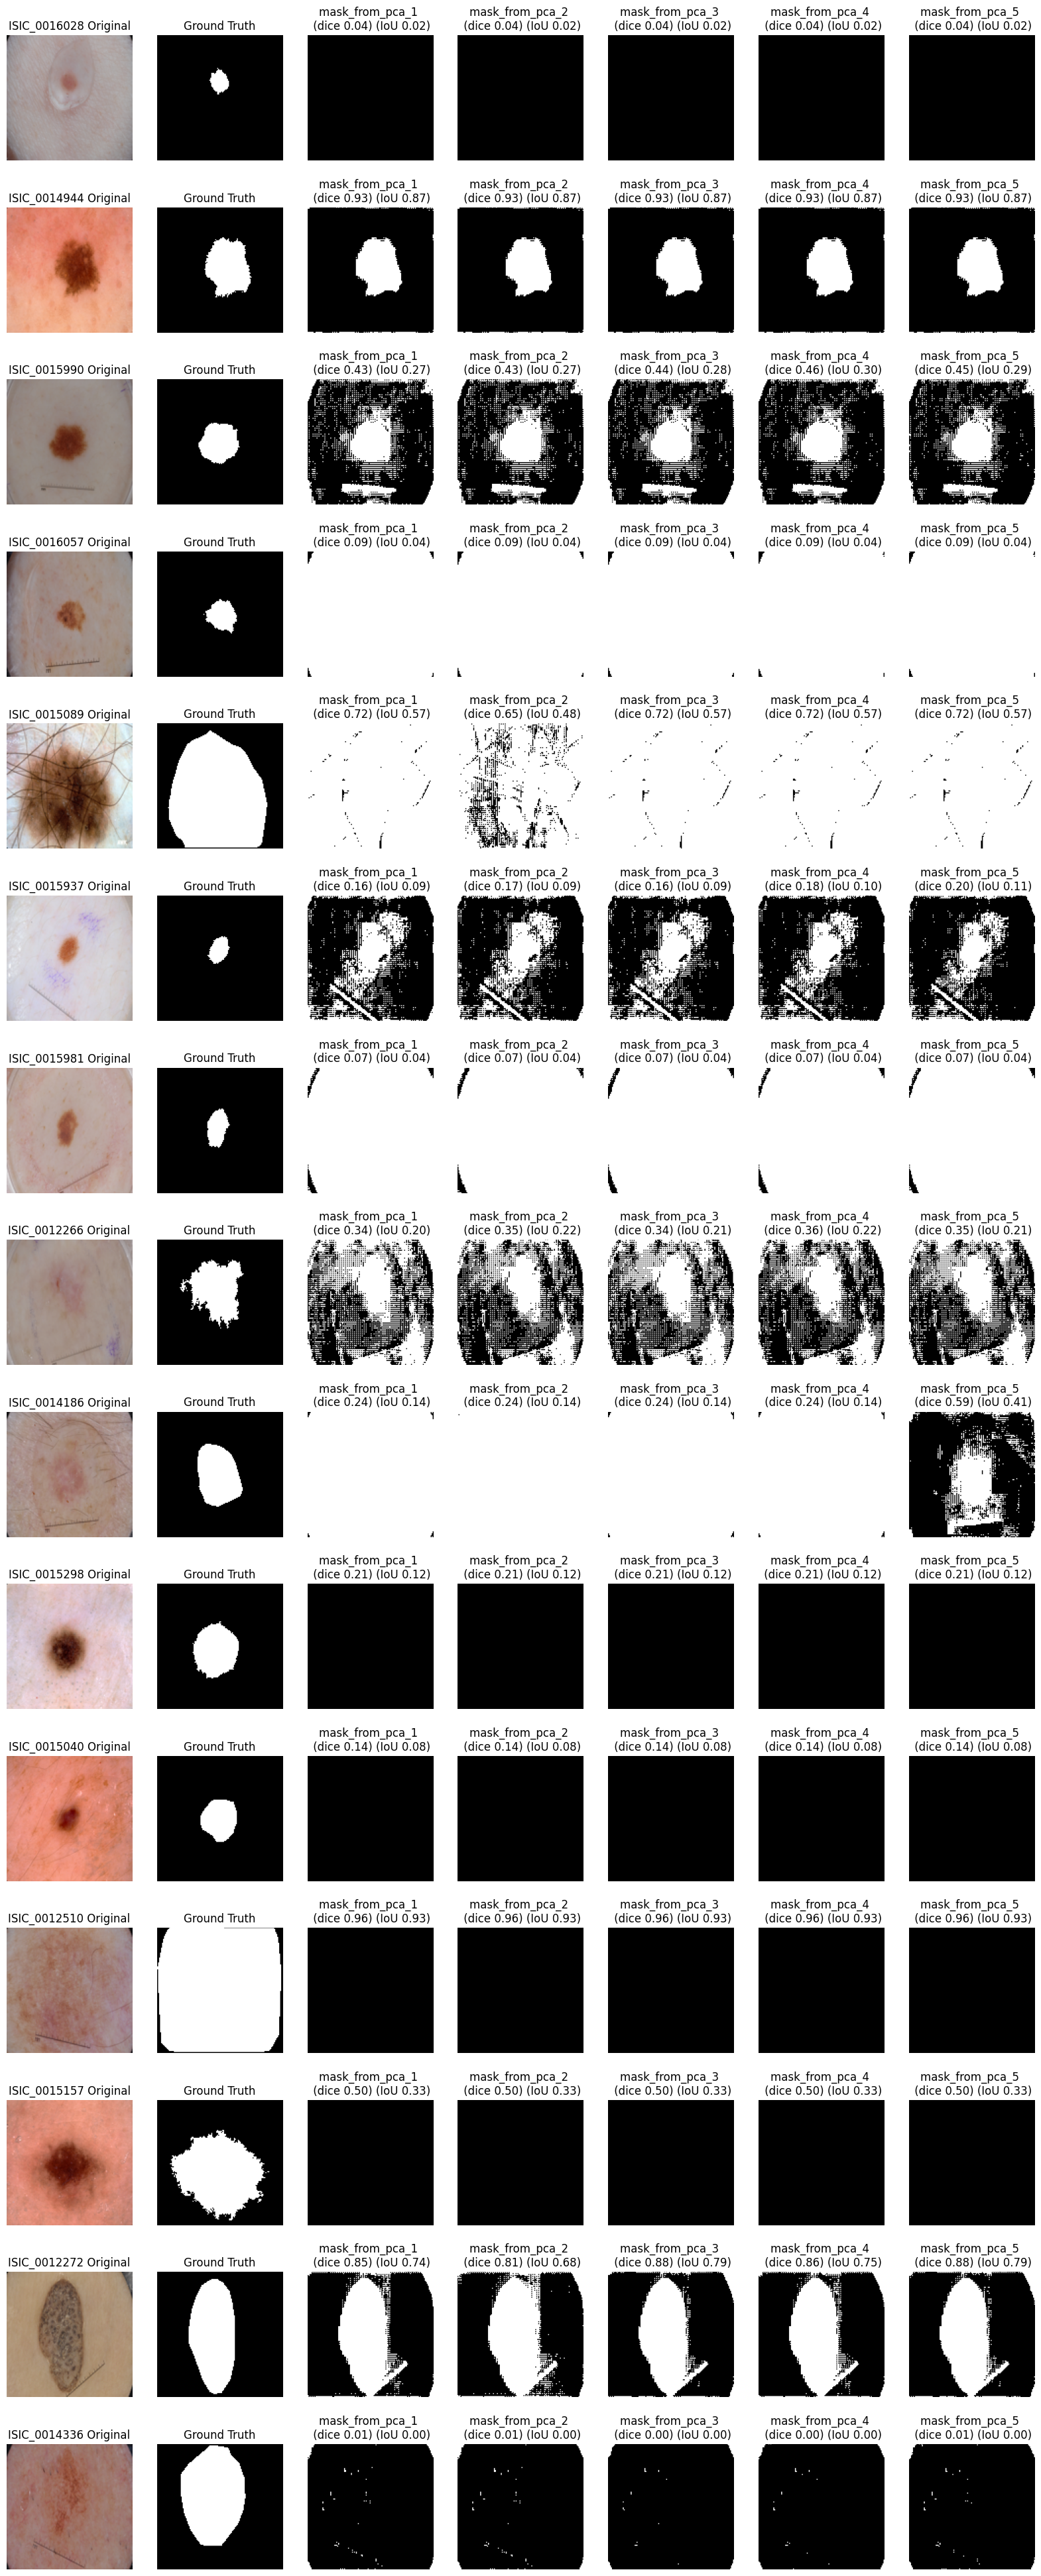

In [17]:
# plot for the first 15 images the mask for each pca component (input)
fig, ax = plt.subplots(15, 7, figsize=(20, 50))
for i, item in enumerate(images_dict.items()):
    if i == 15:
        break
    ax[i, 0].imshow(item[1]['image'])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(item[0] + ' Original')
    ax[i, 1].imshow(item[1]['mask'], cmap='gray')
    ax[i, 1].axis('off')
    ax[i, 1].set_title('Ground Truth')
    for j, matrix in enumerate(item[1]['predicted_masks_pca']):
        ax[i, j+2].imshow(matrix, cmap='gray')
        ax[i, j+2].axis('off')
        ax[i, j+2].set_title(f'mask_from_pca_{j+1} \n (dice {item[1]['dice_scores_predicted_masks_pca'][j]:.2f}) (IoU {item[1]['iou_scores_predicted_masks_pca'][j]:.2f})')

In [18]:
#            # Flatten the matrix to work with probabilities
#            flattened_matrix = matrix.flatten()
#            # Normalize the pixel values to create probabilities
#            probabilities_foreground = flattened_matrix / np.sum(flattened_matrix)
#            # Get the indices of 10 randomly selected points, with higher probabilities for larger values
#            selected_indices_foreground = np.random.choice(len(flattened_matrix), size=n_points_div2, replace=False, p=probabilities_foreground)
#            # Convert the flattened indices back to 2D coordinates
#            selected_points_foreground = np.array(np.unravel_index(selected_indices_foreground, matrix.shape)).T

In [19]:
#            inverted_values = 1.0 - flattened_matrix
#            probabilities_background = inverted_values / np.sum(inverted_values)
#            selected_indices_background = np.random.choice(len(inverted_values), size=n_points_div2, replace=False, p=probabilities_background)
#            selected_points_background = np.array(np.unravel_index(selected_indices_background, matrix.shape)).T

In [20]:
#            mean_value = np.mean(matrix)
#            matrix[matrix < mean_value] = 0
#            matrix[matrix > mean_value] = 1